# Import the necessary packages for images, files, JSONs, and CSVs

In [121]:
#Image reading, writing, and plotting
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage import io
from skimage import img_as_ubyte
from PIL import Image

#numpy
import numpy as np

#File management
import os

#JSON and CSV files
import json
import pandas as pd
import csv

#import hemagso's data cleaner
from utility.preprocessing import center_and_resize, pure_pil_alpha_to_color


%matplotlib inline

# Select which folders to convert (or all of them)

In [122]:
sprites_folder = os.path.join(os.getcwd(),"sprites")
data_folder = os.path.join(os.getcwd(), "data")

#Automatically converts every single folder
all_gen_folders = sorted([f for f in os.listdir(sprites_folder) if not f.startswith(".")])

# !! ALTERNATIVE !!:
#Uncomment the below to only convert the folders from "sprites" that are not already in the "data" folder
in_data_gens_folders = sorted([f for f in os.listdir(data_folder) if (not f.startswith(".") and 
                              os.path.isdir(os.path.join(data_folder, f)))])

#all_gen_folders = list(set(all_gen_folders).difference(in_data_gens_folders))

# !! ALTERNATIVE !!: 
# Uncomment the below line to automatically convert only the specified folders
# all_gen_folders = ["rse"]

print("folders to convert :: ",all_gen_folders)

folders to convert ::  ['bw', 'bw-back', 'dpp', 'dpp-back', 'gsc', 'gsc-back', 'rby', 'rby-back', 'rse', 'rse-back', 'xydex']


# Load Pokedex (JSON file)

In [123]:
with open("pokedex.json") as xyz:
    pokedex = json.load(xyz)

# Convert the files and create a Master List CSV file (for creating train/test sets)

- CSV file named: "aa_masterlist.csv"
- Uses hemagso's conversion code (github located here: https://github.com/hemagso/neuralmon/blob/master/utility/preprocessing.py)
        - NOTE: I removed hemagso's bounding box catch. It gives problems for weird reasons, sometimes. I think the intent is fine, but the execution was problematic
- !!Warning!!: If a sprite is smaller than the Bounding Box (64x64), then the images won't be converted :(

In [125]:
#
# Initial column names (and their corresponding initial values) for the CSV file
#
row_keys = ["pokemon","dex_number","normal","fighting","flying","poison","ground",
        "rock","bug","ghost","steel","fire",
        "water","grass","electric","psychic","ice","dragon","dark","fairy"]
row_vals = [""]+[0]*(len(row_keys)-1)


for gen_folder in all_gen_folders:
    print("***********************************************")
    print(gen_folder)
    print("***********************************************")
    sprites_gen_folder = os.path.join(sprites_folder, gen_folder)
    data_gen_folder    = os.path.join(data_folder,    gen_folder)
    print("sprites_gen_folder :: ", sprites_gen_folder)
    
    #
    #If the folder (e.g. bw) does not exist in data, create it!
    #
    if(not os.path.exists(data_gen_folder)):
        try:
            os.mkdir(data_gen_folder)
        except OSError:
            print("Creation of the directory %s in <data> failed" %data_gen_folder)
        else:
            print("Successfully created the directory %s in <data> "%data_gen_folder)
    #
    #ensure that only png files are being added
    #
    pkm_img_list = [pkm for pkm in os.listdir(sprites_gen_folder) if pkm.endswith(".png")]
    #print(pkm_img_list)
    
    #
    # Create csv list (has rows of Pokemon, num, and [types]). Each row is a dictionary.
    #
    csv_list = []
    
    for pkm_img_string in pkm_img_list:
        sprites_pkm_loc = os.path.join(sprites_gen_folder,pkm_img_string)
        data_pkm_loc = os.path.join(data_gen_folder, pkm_img_string)
        
        pkm_string = pkm_img_string[0:pkm_img_string.index(".png")]
#         print("is ", pkm_string, " in the pokedex? ", pkm_string in pokedex)
#         print("does the pokemon have a type? ", "types" in pokedex[pkm_string])
#         print("does the pokemon have a number? ", "num" in pokedex[pkm_string])
#         print(pokedex[pkm_string]["types"])
        
        if pkm_string in pokedex:
            if "types" in pokedex[pkm_string] and "num" in pokedex[pkm_string]:
                #checks to ensure that the sprite isn't a fanmade pokemon
                if pokedex[pkm_string]["num"] > 0:
                    #
                    # Normalize the pokemon image, transform to RGB, and then save it!
                    #
                    
                    #Load the Pokemon image and then normalize it
                    old_pkm_image = mpimg.imread(sprites_pkm_loc)
                    
                    try:
                        pkm_image = center_and_resize(old_pkm_image)
                    except:
                        print("Couldn't convert ", pkm_string, " in folder ", gen_folder)
                        print("Exiting program. :(")
                        raise ValueError

                    #Use custom RGBA -> RGB method
                    print(pkm_img_string, " has a shape of :: ", pkm_image.shape)
                    if(pkm_image.ndim == 3 and pkm_image.shape[2] == 4):
                        PIL_im = Image.fromarray(np.uint8(pkm_image*255))
                        PIL_im = pure_pil_alpha_to_color(PIL_im)

                        #save the image
                        PIL_im.save(fp=data_pkm_loc)
                    elif(pkm_image.ndim != 3):
                        raise ValueError("The Pokemon Image shape %s in folder %s is not a 3 or 4 channel image" %(pkm_img_string, gen_folder))
                    else:

                        #Already 3-channel; just save the image
                        io.imsave(data_pkm_loc, img_as_ubyte(pkm_image))




                    #
                    # Create a new row entry for the csv list
                    #

                    #Create a dictionary for the row
                    row_dict = dict(zip(row_keys, row_vals))

                    row_dict["pokemon"] = pkm_img_string
                    row_dict["dex_number"] = pokedex[pkm_string]["num"]

                    #Goes through the types (from the pokedex) and sets the corresponding column val in 
                    #the row to 1 (e.g. the fire type column is set to 1 for Magby)
                    for pkm_type in (t.lower() for t in pokedex[pkm_string]["types"]):
                            row_dict[pkm_type] = 1

                    #Append the row to the csv_list
                    csv_list.append(row_dict)

    #
    # Create pandas frame to write into csv file
    #
    df = pd.DataFrame(csv_list,columns=row_keys)
    df.sort_values("dex_number", inplace=True, ascending=True)
    #print(df)
    writeable_df = df.to_csv(os.path.join(data_gen_folder,"aa_masterlist.csv"),encoding="utf-8",index=False)
    print("Completed generating images from folder:: ", gen_folder)

***********************************************
bw
***********************************************
sprites_gen_folder ::  /home/tariq/PokemonTypeNN/sprites/bw
magby.png  has a shape of ::  (64, 64, 4)
axew.png  has a shape of ::  (64, 64, 4)
mismagius.png  has a shape of ::  (64, 64, 4)
electivire.png  has a shape of ::  (64, 64, 4)
tranquill.png  has a shape of ::  (64, 64, 4)
pinsirmega.png  has a shape of ::  (64, 64, 4)
pawniard.png  has a shape of ::  (64, 64, 4)
houndoommega.png  has a shape of ::  (64, 64, 4)
ambipom.png  has a shape of ::  (64, 64, 4)
pikachuphd.png  has a shape of ::  (64, 64, 4)
sandygast.png  has a shape of ::  (64, 64, 4)
oricorio.png  has a shape of ::  (64, 64, 4)
panpour.png  has a shape of ::  (64, 64, 4)
keldeo.png  has a shape of ::  (64, 64, 4)
beldum.png  has a shape of ::  (64, 64, 4)
spoink.png  has a shape of ::  (64, 64, 4)
kyogre.png  has a shape of ::  (64, 64, 4)
oricoriosensu.png  has a shape of ::  (64, 64, 4)
groudonprimal.png  has a shape

rattata.png  has a shape of ::  (64, 64, 4)
miniororange.png  has a shape of ::  (64, 64, 4)
gengar.png  has a shape of ::  (64, 64, 4)
kirlia.png  has a shape of ::  (64, 64, 4)
rhydon.png  has a shape of ::  (64, 64, 4)
arceusice.png  has a shape of ::  (64, 64, 4)
swadloon.png  has a shape of ::  (64, 64, 4)
frogadier.png  has a shape of ::  (64, 64, 4)
onix.png  has a shape of ::  (64, 64, 4)
azumarill.png  has a shape of ::  (64, 64, 4)
pyroar.png  has a shape of ::  (64, 64, 4)
luvdisc.png  has a shape of ::  (64, 64, 4)
wailmer.png  has a shape of ::  (64, 64, 4)
unownr.png  has a shape of ::  (64, 64, 4)
zubat.png  has a shape of ::  (64, 64, 4)
farfetchd.png  has a shape of ::  (64, 64, 4)
rayquazamega.png  has a shape of ::  (64, 64, 4)
pumpkaboolarge.png  has a shape of ::  (64, 64, 4)
sunflora.png  has a shape of ::  (64, 64, 4)
slakoth.png  has a shape of ::  (64, 64, 4)
golbat.png  has a shape of ::  (64, 64, 4)
bewear.png  has a shape of ::  (64, 64, 4)
charizardmegay.pn

zeraora.png  has a shape of ::  (64, 64, 4)
happiny.png  has a shape of ::  (64, 64, 4)
gourgeistlarge.png  has a shape of ::  (64, 64, 4)
simisear.png  has a shape of ::  (64, 64, 4)
skarmory.png  has a shape of ::  (64, 64, 4)
carracosta.png  has a shape of ::  (64, 64, 4)
bayleef.png  has a shape of ::  (64, 64, 4)
tyranitar.png  has a shape of ::  (64, 64, 4)
bronzor.png  has a shape of ::  (64, 64, 4)
hakamoo.png  has a shape of ::  (64, 64, 4)
furfrou.png  has a shape of ::  (64, 64, 4)
flabebeyellow.png  has a shape of ::  (64, 64, 4)
marshtomp.png  has a shape of ::  (64, 64, 4)
fearow.png  has a shape of ::  (64, 64, 4)
florgesyellow.png  has a shape of ::  (64, 64, 4)
sealeo.png  has a shape of ::  (64, 64, 4)
dhelmise.png  has a shape of ::  (64, 64, 4)
pikachulibre.png  has a shape of ::  (64, 64, 4)
claydol.png  has a shape of ::  (64, 64, 4)
persian.png  has a shape of ::  (64, 64, 4)
chatot.png  has a shape of ::  (64, 64, 4)
binacle.png  has a shape of ::  (64, 64, 4)
g

audino.png  has a shape of ::  (64, 64, 4)
cubchoo.png  has a shape of ::  (64, 64, 4)
volbeat.png  has a shape of ::  (64, 64, 4)
heracross.png  has a shape of ::  (64, 64, 4)
trapinch.png  has a shape of ::  (64, 64, 4)
forretress.png  has a shape of ::  (64, 64, 4)
shelmet.png  has a shape of ::  (64, 64, 4)
pachirisu.png  has a shape of ::  (64, 64, 4)
venonat.png  has a shape of ::  (64, 64, 4)
pikachupartner.png  has a shape of ::  (64, 64, 4)
diancie.png  has a shape of ::  (64, 64, 4)
gastly.png  has a shape of ::  (64, 64, 4)
grimer.png  has a shape of ::  (64, 64, 4)
garchompmega.png  has a shape of ::  (64, 64, 4)
gastrodoneast.png  has a shape of ::  (64, 64, 4)
munchlax.png  has a shape of ::  (64, 64, 4)
relicanth.png  has a shape of ::  (64, 64, 4)
pikipek.png  has a shape of ::  (64, 64, 4)
azurill.png  has a shape of ::  (64, 64, 4)
sandshrewalola.png  has a shape of ::  (64, 64, 4)
flareon.png  has a shape of ::  (64, 64, 4)
whirlipede.png  has a shape of ::  (64, 64,

sunkern.png  has a shape of ::  (64, 64, 4)
scizormega.png  has a shape of ::  (64, 64, 4)
mienfoo.png  has a shape of ::  (64, 64, 4)
roserade.png  has a shape of ::  (64, 64, 4)
gloom.png  has a shape of ::  (64, 64, 4)
krookodile.png  has a shape of ::  (64, 64, 4)
suicune.png  has a shape of ::  (64, 64, 4)
sawsbucksummer.png  has a shape of ::  (64, 64, 4)
diglett.png  has a shape of ::  (64, 64, 4)
snubbull.png  has a shape of ::  (64, 64, 4)
scyther.png  has a shape of ::  (64, 64, 4)
eelektross.png  has a shape of ::  (64, 64, 4)
rapidash.png  has a shape of ::  (64, 64, 4)
silvallyfighting.png  has a shape of ::  (64, 64, 4)
castform.png  has a shape of ::  (64, 64, 4)
jigglypuff.png  has a shape of ::  (64, 64, 4)
gallademega.png  has a shape of ::  (64, 64, 4)
omastar.png  has a shape of ::  (64, 64, 4)
gourgeistsuper.png  has a shape of ::  (64, 64, 4)
virizion.png  has a shape of ::  (64, 64, 4)
garbodor.png  has a shape of ::  (64, 64, 4)
nuzleaf.png  has a shape of ::  (

gothita.png  has a shape of ::  (64, 64, 4)
mareep.png  has a shape of ::  (64, 64, 4)
landorus.png  has a shape of ::  (64, 64, 4)
pikachuunova.png  has a shape of ::  (64, 64, 4)
burmysandy.png  has a shape of ::  (64, 64, 4)
zorua.png  has a shape of ::  (64, 64, 4)
goodra.png  has a shape of ::  (64, 64, 4)
haxorus.png  has a shape of ::  (64, 64, 4)
finneon.png  has a shape of ::  (64, 64, 4)
chansey.png  has a shape of ::  (64, 64, 4)
corphish.png  has a shape of ::  (64, 64, 4)
graveleralola.png  has a shape of ::  (64, 64, 4)
arceusgrass.png  has a shape of ::  (64, 64, 4)
swoobat.png  has a shape of ::  (64, 64, 4)
spinarak.png  has a shape of ::  (64, 64, 4)
kabutops.png  has a shape of ::  (64, 64, 4)
galvantula.png  has a shape of ::  (64, 64, 4)
mareanie.png  has a shape of ::  (64, 64, 4)
kommoo.png  has a shape of ::  (64, 64, 4)
throh.png  has a shape of ::  (64, 64, 4)
weezing.png  has a shape of ::  (64, 64, 4)
unownk.png  has a shape of ::  (64, 64, 4)
bounsweet.png 

mewtwo.png  has a shape of ::  (64, 64, 4)
machop.png  has a shape of ::  (64, 64, 4)
jellicent.png  has a shape of ::  (64, 64, 4)
grovyle.png  has a shape of ::  (64, 64, 4)
loudred.png  has a shape of ::  (64, 64, 4)
krokorok.png  has a shape of ::  (64, 64, 4)
floetteblue.png  has a shape of ::  (64, 64, 4)
genesectshock.png  has a shape of ::  (64, 64, 4)
kakuna.png  has a shape of ::  (64, 64, 4)
zigzagoon.png  has a shape of ::  (64, 64, 4)
sudowoodo.png  has a shape of ::  (64, 64, 4)
audinomega.png  has a shape of ::  (64, 64, 4)
stunky.png  has a shape of ::  (64, 64, 4)
dwebble.png  has a shape of ::  (64, 64, 4)
kecleon.png  has a shape of ::  (64, 64, 4)
medicham.png  has a shape of ::  (64, 64, 4)
stakataka.png  has a shape of ::  (64, 64, 4)
barbaracle.png  has a shape of ::  (64, 64, 4)
magikarp.png  has a shape of ::  (64, 64, 4)
hoothoot.png  has a shape of ::  (64, 64, 4)
natu.png  has a shape of ::  (64, 64, 4)
vespiquen.png  has a shape of ::  (64, 64, 4)
vibrava.p

delphox.png  has a shape of ::  (64, 64, 4)
geodudealola.png  has a shape of ::  (64, 64, 4)
clamperl.png  has a shape of ::  (64, 64, 4)
lycanroc.png  has a shape of ::  (64, 64, 4)
torchic.png  has a shape of ::  (64, 64, 4)
entei.png  has a shape of ::  (64, 64, 4)
swablu.png  has a shape of ::  (64, 64, 4)
kangaskhanmega.png  has a shape of ::  (64, 64, 4)
necrozmaultra.png  has a shape of ::  (64, 64, 4)
nidorina.png  has a shape of ::  (64, 64, 4)
stufful.png  has a shape of ::  (64, 64, 4)
swanna.png  has a shape of ::  (64, 64, 4)
noctowl.png  has a shape of ::  (64, 64, 4)
corsola.png  has a shape of ::  (64, 64, 4)
genesectdouse.png  has a shape of ::  (64, 64, 4)
tangrowth.png  has a shape of ::  (64, 64, 4)
medichammega.png  has a shape of ::  (64, 64, 4)
pangoro.png  has a shape of ::  (64, 64, 4)
hypno.png  has a shape of ::  (64, 64, 4)
rotomfrost.png  has a shape of ::  (64, 64, 4)
cubone.png  has a shape of ::  (64, 64, 4)
scolipede.png  has a shape of ::  (64, 64, 4)


numel.png  has a shape of ::  (64, 64, 4)
pikachubelle.png  has a shape of ::  (64, 64, 4)
diglettalola.png  has a shape of ::  (64, 64, 4)
electabuzz.png  has a shape of ::  (64, 64, 4)
litleo.png  has a shape of ::  (64, 64, 4)
exeggutoralola.png  has a shape of ::  (64, 64, 4)
cleffa.png  has a shape of ::  (64, 64, 4)
wormadamsandy.png  has a shape of ::  (64, 64, 4)
shayminsky.png  has a shape of ::  (64, 64, 4)
stoutland.png  has a shape of ::  (64, 64, 4)
jolteon.png  has a shape of ::  (64, 64, 4)
poliwrath.png  has a shape of ::  (64, 64, 4)
drapion.png  has a shape of ::  (64, 64, 4)
spearow.png  has a shape of ::  (64, 64, 4)
steenee.png  has a shape of ::  (64, 64, 4)
miniorviolet.png  has a shape of ::  (64, 64, 4)
seel.png  has a shape of ::  (64, 64, 4)
terrakion.png  has a shape of ::  (64, 64, 4)
minun.png  has a shape of ::  (64, 64, 4)
manaphy.png  has a shape of ::  (64, 64, 4)
arceus.png  has a shape of ::  (64, 64, 4)
vivillon.png  has a shape of ::  (64, 64, 4)
u

graveler.png  has a shape of ::  (64, 64, 4)
unownn.png  has a shape of ::  (64, 64, 4)
seadra.png  has a shape of ::  (64, 64, 4)
palpitoad.png  has a shape of ::  (64, 64, 4)
pancham.png  has a shape of ::  (64, 64, 4)
trubbish.png  has a shape of ::  (64, 64, 4)
unownx.png  has a shape of ::  (64, 64, 4)
luxray.png  has a shape of ::  (64, 64, 4)
chinchou.png  has a shape of ::  (64, 64, 4)
electrode.png  has a shape of ::  (64, 64, 4)
combee.png  has a shape of ::  (64, 64, 4)
typhlosion.png  has a shape of ::  (64, 64, 4)
magnemite.png  has a shape of ::  (64, 64, 4)
tentacruel.png  has a shape of ::  (64, 64, 4)
vanillish.png  has a shape of ::  (64, 64, 4)
seismitoad.png  has a shape of ::  (64, 64, 4)
unownl.png  has a shape of ::  (64, 64, 4)
cherubi.png  has a shape of ::  (64, 64, 4)
bagon.png  has a shape of ::  (64, 64, 4)
avalugg.png  has a shape of ::  (64, 64, 4)
spiritomb.png  has a shape of ::  (64, 64, 4)
bouffalant.png  has a shape of ::  (64, 64, 4)
phanpy.png  has

heatmor.png  has a shape of ::  (64, 64, 4)
minccino.png  has a shape of ::  (64, 64, 4)
passimian.png  has a shape of ::  (64, 64, 4)
spinda.png  has a shape of ::  (64, 64, 4)
poipole.png  has a shape of ::  (64, 64, 4)
escavalier.png  has a shape of ::  (64, 64, 4)
abra.png  has a shape of ::  (64, 64, 4)
simipour.png  has a shape of ::  (64, 64, 4)
bisharp.png  has a shape of ::  (64, 64, 4)
gothita.png  has a shape of ::  (64, 64, 4)
mareep.png  has a shape of ::  (64, 64, 4)
landorus.png  has a shape of ::  (64, 64, 4)
pikachuunova.png  has a shape of ::  (64, 64, 4)
burmysandy.png  has a shape of ::  (64, 64, 4)
zorua.png  has a shape of ::  (64, 64, 4)
goodra.png  has a shape of ::  (64, 64, 4)
haxorus.png  has a shape of ::  (64, 64, 4)
finneon.png  has a shape of ::  (64, 64, 4)
chansey.png  has a shape of ::  (64, 64, 4)
corphish.png  has a shape of ::  (64, 64, 4)
graveleralola.png  has a shape of ::  (64, 64, 4)
arceusgrass.png  has a shape of ::  (64, 64, 4)
swoobat.png  

unown.png  has a shape of ::  (64, 64, 4)
omanyte.png  has a shape of ::  (64, 64, 4)
wigglytuff.png  has a shape of ::  (64, 64, 4)
togekiss.png  has a shape of ::  (64, 64, 4)
ditto.png  has a shape of ::  (64, 64, 4)
primeape.png  has a shape of ::  (64, 64, 4)
ralts.png  has a shape of ::  (64, 64, 4)
porygon.png  has a shape of ::  (64, 64, 4)
wynaut.png  has a shape of ::  (64, 64, 4)
arceusground.png  has a shape of ::  (64, 64, 4)
blastoise.png  has a shape of ::  (64, 64, 4)
golduck.png  has a shape of ::  (64, 64, 4)
wingull.png  has a shape of ::  (64, 64, 4)
gyarados.png  has a shape of ::  (64, 64, 4)
murkrow.png  has a shape of ::  (64, 64, 4)
croagunk.png  has a shape of ::  (64, 64, 4)
donphan.png  has a shape of ::  (64, 64, 4)
delcatty.png  has a shape of ::  (64, 64, 4)
kricketot.png  has a shape of ::  (64, 64, 4)
caterpie.png  has a shape of ::  (64, 64, 4)
wobbuffet.png  has a shape of ::  (64, 64, 4)
nidoranm.png  has a shape of ::  (64, 64, 4)
weavile.png  has a

hariyama.png  has a shape of ::  (64, 64, 4)
bulbasaur.png  has a shape of ::  (64, 64, 4)
drifblim.png  has a shape of ::  (64, 64, 4)
swalot.png  has a shape of ::  (64, 64, 4)
buneary.png  has a shape of ::  (64, 64, 4)
voltorb.png  has a shape of ::  (64, 64, 4)
cresselia.png  has a shape of ::  (64, 64, 4)
qwilfish.png  has a shape of ::  (64, 64, 4)
miltank.png  has a shape of ::  (64, 64, 4)
arceusdragon.png  has a shape of ::  (64, 64, 4)
dialga.png  has a shape of ::  (64, 64, 4)
deoxys.png  has a shape of ::  (64, 64, 4)
koffing.png  has a shape of ::  (64, 64, 4)
granbull.png  has a shape of ::  (64, 64, 4)
marill.png  has a shape of ::  (64, 64, 4)
wurmple.png  has a shape of ::  (64, 64, 4)
kadabra.png  has a shape of ::  (64, 64, 4)
pichuspikyeared.png  has a shape of ::  (64, 64, 4)
smeargle.png  has a shape of ::  (64, 64, 4)
swellow.png  has a shape of ::  (64, 64, 4)
kabuto.png  has a shape of ::  (64, 64, 4)
castformsnowy.png  has a shape of ::  (64, 64, 4)
floatzel.

ampharos.png  has a shape of ::  (64, 64, 4)
dustox.png  has a shape of ::  (64, 64, 4)
snorlax.png  has a shape of ::  (64, 64, 4)
magnezone.png  has a shape of ::  (64, 64, 4)
piplup.png  has a shape of ::  (64, 64, 4)
silcoon.png  has a shape of ::  (64, 64, 4)
lapras.png  has a shape of ::  (64, 64, 4)
mantine.png  has a shape of ::  (64, 64, 4)
krabby.png  has a shape of ::  (64, 64, 4)
meganium.png  has a shape of ::  (64, 64, 4)
wartortle.png  has a shape of ::  (64, 64, 4)
bastiodon.png  has a shape of ::  (64, 64, 4)
lickilicky.png  has a shape of ::  (64, 64, 4)
poliwag.png  has a shape of ::  (64, 64, 4)
masquerain.png  has a shape of ::  (64, 64, 4)
xatu.png  has a shape of ::  (64, 64, 4)
mesprit.png  has a shape of ::  (64, 64, 4)
hoppip.png  has a shape of ::  (64, 64, 4)
sceptile.png  has a shape of ::  (64, 64, 4)
slowbro.png  has a shape of ::  (64, 64, 4)
grumpig.png  has a shape of ::  (64, 64, 4)
quilava.png  has a shape of ::  (64, 64, 4)
kangaskhan.png  has a sha

leafeon.png  has a shape of ::  (64, 64, 4)
poochyena.png  has a shape of ::  (64, 64, 4)
empoleon.png  has a shape of ::  (64, 64, 4)
marowak.png  has a shape of ::  (64, 64, 4)
treecko.png  has a shape of ::  (64, 64, 4)
exeggutor.png  has a shape of ::  (64, 64, 4)
charizard.png  has a shape of ::  (64, 64, 4)
oddish.png  has a shape of ::  (64, 64, 4)
crobat.png  has a shape of ::  (64, 64, 4)
baltoy.png  has a shape of ::  (64, 64, 4)
arceusdark.png  has a shape of ::  (64, 64, 4)
espeon.png  has a shape of ::  (64, 64, 4)
bellossom.png  has a shape of ::  (64, 64, 4)
alakazam.png  has a shape of ::  (64, 64, 4)
honchkrow.png  has a shape of ::  (64, 64, 4)
heatran.png  has a shape of ::  (64, 64, 4)
arceusfighting.png  has a shape of ::  (64, 64, 4)
tyrogue.png  has a shape of ::  (64, 64, 4)
shieldon.png  has a shape of ::  (64, 64, 4)
charmander.png  has a shape of ::  (64, 64, 4)
torkoal.png  has a shape of ::  (64, 64, 4)
beedrill.png  has a shape of ::  (64, 64, 4)
nidoqueen

mantyke.png  has a shape of ::  (64, 64, 4)
whiscash.png  has a shape of ::  (64, 64, 4)
grotle.png  has a shape of ::  (64, 64, 4)
machamp.png  has a shape of ::  (64, 64, 4)
skiploom.png  has a shape of ::  (64, 64, 4)
pidgeot.png  has a shape of ::  (64, 64, 4)
piloswine.png  has a shape of ::  (64, 64, 4)
torterra.png  has a shape of ::  (64, 64, 4)
golem.png  has a shape of ::  (64, 64, 4)
salamence.png  has a shape of ::  (64, 64, 4)
lombre.png  has a shape of ::  (64, 64, 4)
budew.png  has a shape of ::  (64, 64, 4)
smoochum.png  has a shape of ::  (64, 64, 4)
walrein.png  has a shape of ::  (64, 64, 4)
raticate.png  has a shape of ::  (64, 64, 4)
metang.png  has a shape of ::  (64, 64, 4)
arbok.png  has a shape of ::  (64, 64, 4)
anorith.png  has a shape of ::  (64, 64, 4)
zangoose.png  has a shape of ::  (64, 64, 4)
arcanine.png  has a shape of ::  (64, 64, 4)
aerodactyl.png  has a shape of ::  (64, 64, 4)
arceusbug.png  has a shape of ::  (64, 64, 4)
tangela.png  has a shape 

exeggutor.png  has a shape of ::  (64, 64, 4)
charizard.png  has a shape of ::  (64, 64, 4)
oddish.png  has a shape of ::  (64, 64, 4)
crobat.png  has a shape of ::  (64, 64, 4)
espeon.png  has a shape of ::  (64, 64, 4)
bellossom.png  has a shape of ::  (64, 64, 4)
alakazam.png  has a shape of ::  (64, 64, 4)
tyrogue.png  has a shape of ::  (64, 64, 4)
charmander.png  has a shape of ::  (64, 64, 4)
beedrill.png  has a shape of ::  (64, 64, 4)
nidoqueen.png  has a shape of ::  (64, 64, 4)
houndour.png  has a shape of ::  (64, 64, 4)
paras.png  has a shape of ::  (64, 64, 4)
horsea.png  has a shape of ::  (64, 64, 4)
vileplume.png  has a shape of ::  (64, 64, 4)
weedle.png  has a shape of ::  (64, 64, 4)
teddiursa.png  has a shape of ::  (64, 64, 4)
parasect.png  has a shape of ::  (64, 64, 4)
magcargo.png  has a shape of ::  (64, 64, 4)
jynx.png  has a shape of ::  (64, 64, 4)
dratini.png  has a shape of ::  (64, 64, 4)
girafarig.png  has a shape of ::  (64, 64, 4)
igglybuff.png  has a

gyarados.png  has a shape of ::  (64, 64, 4)
murkrow.png  has a shape of ::  (64, 64, 4)
donphan.png  has a shape of ::  (64, 64, 4)
caterpie.png  has a shape of ::  (64, 64, 4)
wobbuffet.png  has a shape of ::  (64, 64, 4)
nidoranm.png  has a shape of ::  (64, 64, 4)
porygon2.png  has a shape of ::  (64, 64, 4)
nidoranf.png  has a shape of ::  (64, 64, 4)
entei.png  has a shape of ::  (64, 64, 4)
nidorina.png  has a shape of ::  (64, 64, 4)
noctowl.png  has a shape of ::  (64, 64, 4)
corsola.png  has a shape of ::  (64, 64, 4)
hypno.png  has a shape of ::  (64, 64, 4)
cubone.png  has a shape of ::  (64, 64, 4)
venomoth.png  has a shape of ::  (64, 64, 4)
ponyta.png  has a shape of ::  (64, 64, 4)
stantler.png  has a shape of ::  (64, 64, 4)
shuckle.png  has a shape of ::  (64, 64, 4)
lanturn.png  has a shape of ::  (64, 64, 4)
umbreon.png  has a shape of ::  (64, 64, 4)
slowpoke.png  has a shape of ::  (64, 64, 4)
bellsprout.png  has a shape of ::  (64, 64, 4)
clefable.png  has a shap

kakuna.png  has a shape of ::  (64, 64, 4)
magikarp.png  has a shape of ::  (64, 64, 4)
nidoking.png  has a shape of ::  (64, 64, 4)
hitmonlee.png  has a shape of ::  (64, 64, 4)
vulpix.png  has a shape of ::  (64, 64, 4)
charmeleon.png  has a shape of ::  (64, 64, 4)
magmar.png  has a shape of ::  (64, 64, 4)
pikachu.png  has a shape of ::  (64, 64, 4)
muk.png  has a shape of ::  (64, 64, 4)
rattata.png  has a shape of ::  (64, 64, 4)
gengar.png  has a shape of ::  (64, 64, 4)
rhydon.png  has a shape of ::  (64, 64, 4)
onix.png  has a shape of ::  (64, 64, 4)
zubat.png  has a shape of ::  (64, 64, 4)
farfetchd.png  has a shape of ::  (64, 64, 4)
golbat.png  has a shape of ::  (64, 64, 4)
hitmonchan.png  has a shape of ::  (64, 64, 4)
ekans.png  has a shape of ::  (64, 64, 4)
starmie.png  has a shape of ::  (64, 64, 4)
dragonair.png  has a shape of ::  (64, 64, 4)
nidorino.png  has a shape of ::  (64, 64, 4)
articuno.png  has a shape of ::  (64, 64, 4)
omanyte.png  has a shape of ::  (

nidoqueen.png  has a shape of ::  (64, 64, 4)
paras.png  has a shape of ::  (64, 64, 4)
horsea.png  has a shape of ::  (64, 64, 4)
vileplume.png  has a shape of ::  (64, 64, 4)
weedle.png  has a shape of ::  (64, 64, 4)
parasect.png  has a shape of ::  (64, 64, 4)
jynx.png  has a shape of ::  (64, 64, 4)
dratini.png  has a shape of ::  (64, 64, 4)
sandslash.png  has a shape of ::  (64, 64, 4)
electabuzz.png  has a shape of ::  (64, 64, 4)
jolteon.png  has a shape of ::  (64, 64, 4)
poliwrath.png  has a shape of ::  (64, 64, 4)
spearow.png  has a shape of ::  (64, 64, 4)
seel.png  has a shape of ::  (64, 64, 4)
exeggcute.png  has a shape of ::  (64, 64, 4)
geodude.png  has a shape of ::  (64, 64, 4)
tauros.png  has a shape of ::  (64, 64, 4)
venonat.png  has a shape of ::  (64, 64, 4)
gastly.png  has a shape of ::  (64, 64, 4)
grimer.png  has a shape of ::  (64, 64, 4)
flareon.png  has a shape of ::  (64, 64, 4)
cloyster.png  has a shape of ::  (64, 64, 4)
dragonite.png  has a shape of 

hypno.png  has a shape of ::  (64, 64, 4)
cubone.png  has a shape of ::  (64, 64, 4)
venomoth.png  has a shape of ::  (64, 64, 4)
milotic.png  has a shape of ::  (64, 64, 4)
ponyta.png  has a shape of ::  (64, 64, 4)
exploud.png  has a shape of ::  (64, 64, 4)
stantler.png  has a shape of ::  (64, 64, 4)
ninjask.png  has a shape of ::  (64, 64, 4)
whismur.png  has a shape of ::  (64, 64, 4)
shuckle.png  has a shape of ::  (64, 64, 4)
lanturn.png  has a shape of ::  (64, 64, 4)
umbreon.png  has a shape of ::  (64, 64, 4)
slowpoke.png  has a shape of ::  (64, 64, 4)
bellsprout.png  has a shape of ::  (64, 64, 4)
mudkip.png  has a shape of ::  (64, 64, 4)
clefable.png  has a shape of ::  (64, 64, 4)
barboach.png  has a shape of ::  (64, 64, 4)
beautifly.png  has a shape of ::  (64, 64, 4)
blaziken.png  has a shape of ::  (64, 64, 4)
doduo.png  has a shape of ::  (64, 64, 4)
growlithe.png  has a shape of ::  (64, 64, 4)
banette.png  has a shape of ::  (64, 64, 4)
swampert.png  has a shape 

remoraid.png  has a shape of ::  (64, 64, 4)
hooh.png  has a shape of ::  (64, 64, 4)
vigoroth.png  has a shape of ::  (64, 64, 4)
shellder.png  has a shape of ::  (64, 64, 4)
tropius.png  has a shape of ::  (64, 64, 4)
linoone.png  has a shape of ::  (64, 64, 4)
lunatone.png  has a shape of ::  (64, 64, 4)
feraligatr.png  has a shape of ::  (64, 64, 4)
sneasel.png  has a shape of ::  (64, 64, 4)
scizor.png  has a shape of ::  (64, 64, 4)
tentacool.png  has a shape of ::  (64, 64, 4)
houndoom.png  has a shape of ::  (64, 64, 4)
drowzee.png  has a shape of ::  (64, 64, 4)
cyndaquil.png  has a shape of ::  (64, 64, 4)
castformrainy.png  has a shape of ::  (64, 64, 4)
gorebyss.png  has a shape of ::  (64, 64, 4)
taillow.png  has a shape of ::  (64, 64, 4)
ludicolo.png  has a shape of ::  (64, 64, 4)
chimecho.png  has a shape of ::  (64, 64, 4)
combusken.png  has a shape of ::  (64, 64, 4)
slugma.png  has a shape of ::  (64, 64, 4)
spinda.png  has a shape of ::  (64, 64, 4)
abra.png  has a

swampert.png  has a shape of ::  (64, 64, 4)
snorunt.png  has a shape of ::  (64, 64, 4)
slowking.png  has a shape of ::  (64, 64, 4)
skarmory.png  has a shape of ::  (64, 64, 4)
bayleef.png  has a shape of ::  (64, 64, 4)
tyranitar.png  has a shape of ::  (64, 64, 4)
marshtomp.png  has a shape of ::  (64, 64, 4)
fearow.png  has a shape of ::  (64, 64, 4)
sealeo.png  has a shape of ::  (64, 64, 4)
claydol.png  has a shape of ::  (64, 64, 4)
persian.png  has a shape of ::  (64, 64, 4)
mightyena.png  has a shape of ::  (64, 64, 4)
poochyena.png  has a shape of ::  (64, 64, 4)
marowak.png  has a shape of ::  (64, 64, 4)
treecko.png  has a shape of ::  (64, 64, 4)
exeggutor.png  has a shape of ::  (64, 64, 4)
charizard.png  has a shape of ::  (64, 64, 4)
oddish.png  has a shape of ::  (64, 64, 4)
crobat.png  has a shape of ::  (64, 64, 4)
baltoy.png  has a shape of ::  (64, 64, 4)
espeon.png  has a shape of ::  (64, 64, 4)
bellossom.png  has a shape of ::  (64, 64, 4)
alakazam.png  has a s

dugtrio.png  has a shape of ::  (64, 64, 4)
cacnea.png  has a shape of ::  (64, 64, 4)
sentret.png  has a shape of ::  (64, 64, 4)
breloom.png  has a shape of ::  (64, 64, 4)
togetic.png  has a shape of ::  (64, 64, 4)
clefairy.png  has a shape of ::  (64, 64, 4)
dewgong.png  has a shape of ::  (64, 64, 4)
Completed generating images from folder::  rse-back
***********************************************
xydex
***********************************************
sprites_gen_folder ::  /home/tariq/PokemonTypeNN/sprites/xydex
magby.png  has a shape of ::  (64, 64, 4)
axew.png  has a shape of ::  (64, 64, 4)
mismagius.png  has a shape of ::  (64, 64, 4)
electivire.png  has a shape of ::  (64, 64, 4)
tranquill.png  has a shape of ::  (64, 64, 4)
pinsirmega.png  has a shape of ::  (64, 64, 4)
pawniard.png  has a shape of ::  (64, 64, 4)
houndoommega.png  has a shape of ::  (64, 64, 4)
ambipom.png  has a shape of ::  (64, 64, 4)
sandygast.png  has a shape of ::  (64, 64, 4)
oricorio.png  has a sh

rotomheat.png  has a shape of ::  (64, 64, 4)
dugtrioalola.png  has a shape of ::  (64, 64, 4)
jangmoo.png  has a shape of ::  (64, 64, 4)
muk.png  has a shape of ::  (64, 64, 4)
gligar.png  has a shape of ::  (64, 64, 4)
cameruptmega.png  has a shape of ::  (64, 64, 4)
pelipper.png  has a shape of ::  (64, 64, 4)
latias.png  has a shape of ::  (64, 64, 4)
aggronmega.png  has a shape of ::  (64, 64, 4)
furfroumatron.png  has a shape of ::  (64, 64, 4)
mewtwomegay.png  has a shape of ::  (64, 64, 4)
silvallyground.png  has a shape of ::  (64, 64, 4)
swinub.png  has a shape of ::  (64, 64, 4)
tyrunt.png  has a shape of ::  (64, 64, 4)
gothorita.png  has a shape of ::  (64, 64, 4)
sandile.png  has a shape of ::  (64, 64, 4)
sawsbuckautumn.png  has a shape of ::  (64, 64, 4)
rattata.png  has a shape of ::  (64, 64, 4)
miniororange.png  has a shape of ::  (64, 64, 4)
gengar.png  has a shape of ::  (64, 64, 4)
kirlia.png  has a shape of ::  (64, 64, 4)
rhydon.png  has a shape of ::  (64, 64,

stantler.png  has a shape of ::  (64, 64, 4)
ninjask.png  has a shape of ::  (64, 64, 4)
ducklett.png  has a shape of ::  (64, 64, 4)
whismur.png  has a shape of ::  (64, 64, 4)
vivillonicysnow.png  has a shape of ::  (64, 64, 4)
staraptor.png  has a shape of ::  (64, 64, 4)
deerlingsummer.png  has a shape of ::  (64, 64, 4)
shuckle.png  has a shape of ::  (64, 64, 4)
lanturn.png  has a shape of ::  (64, 64, 4)
infernape.png  has a shape of ::  (64, 64, 4)
umbreon.png  has a shape of ::  (64, 64, 4)
slowpoke.png  has a shape of ::  (64, 64, 4)
rotomwash.png  has a shape of ::  (64, 64, 4)
unowng.png  has a shape of ::  (64, 64, 4)
bellsprout.png  has a shape of ::  (64, 64, 4)
bidoof.png  has a shape of ::  (64, 64, 4)
mudkip.png  has a shape of ::  (64, 64, 4)
clefable.png  has a shape of ::  (64, 64, 4)
unownu.png  has a shape of ::  (64, 64, 4)
rotommow.png  has a shape of ::  (64, 64, 4)
barboach.png  has a shape of ::  (64, 64, 4)
pikachuhoenn.png  has a shape of ::  (64, 64, 4)
b

vivillon.png  has a shape of ::  (64, 64, 4)
ursaring.png  has a shape of ::  (64, 64, 4)
unownquestion.png  has a shape of ::  (64, 64, 4)
beartic.png  has a shape of ::  (64, 64, 4)
thundurustherian.png  has a shape of ::  (64, 64, 4)
ariados.png  has a shape of ::  (64, 64, 4)
lugia.png  has a shape of ::  (64, 64, 4)
arceusrock.png  has a shape of ::  (64, 64, 4)
scatterbug.png  has a shape of ::  (64, 64, 4)
carvanha.png  has a shape of ::  (64, 64, 4)
lopunny.png  has a shape of ::  (64, 64, 4)
metagross.png  has a shape of ::  (64, 64, 4)
florges.png  has a shape of ::  (64, 64, 4)
croconaw.png  has a shape of ::  (64, 64, 4)
solrock.png  has a shape of ::  (64, 64, 4)
abomasnow.png  has a shape of ::  (64, 64, 4)
litten.png  has a shape of ::  (64, 64, 4)
exeggcute.png  has a shape of ::  (64, 64, 4)
popplio.png  has a shape of ::  (64, 64, 4)
yanmega.png  has a shape of ::  (64, 64, 4)
duskull.png  has a shape of ::  (64, 64, 4)
ferroseed.png  has a shape of ::  (64, 64, 4)
pu

chinchou.png  has a shape of ::  (64, 64, 4)
electrode.png  has a shape of ::  (64, 64, 4)
combee.png  has a shape of ::  (64, 64, 4)
typhlosion.png  has a shape of ::  (64, 64, 4)
magnemite.png  has a shape of ::  (64, 64, 4)
tentacruel.png  has a shape of ::  (64, 64, 4)
vivillonarchipelago.png  has a shape of ::  (64, 64, 4)
vanillish.png  has a shape of ::  (64, 64, 4)
seismitoad.png  has a shape of ::  (64, 64, 4)
unownl.png  has a shape of ::  (64, 64, 4)
cherubi.png  has a shape of ::  (64, 64, 4)
bagon.png  has a shape of ::  (64, 64, 4)
avalugg.png  has a shape of ::  (64, 64, 4)
spiritomb.png  has a shape of ::  (64, 64, 4)
bouffalant.png  has a shape of ::  (64, 64, 4)
phanpy.png  has a shape of ::  (64, 64, 4)
quilladin.png  has a shape of ::  (64, 64, 4)
sunkern.png  has a shape of ::  (64, 64, 4)
scizormega.png  has a shape of ::  (64, 64, 4)
mienfoo.png  has a shape of ::  (64, 64, 4)
roserade.png  has a shape of ::  (64, 64, 4)
gloom.png  has a shape of ::  (64, 64, 4)


shiinotic.png  has a shape of ::  (64, 64, 4)
watchog.png  has a shape of ::  (64, 64, 4)
sawsbuckwinter.png  has a shape of ::  (64, 64, 4)
floettewhite.png  has a shape of ::  (64, 64, 4)
froslass.png  has a shape of ::  (64, 64, 4)
chimecho.png  has a shape of ::  (64, 64, 4)
frillish.png  has a shape of ::  (64, 64, 4)
duosion.png  has a shape of ::  (64, 64, 4)
combusken.png  has a shape of ::  (64, 64, 4)
slugma.png  has a shape of ::  (64, 64, 4)
morelull.png  has a shape of ::  (64, 64, 4)
heatmor.png  has a shape of ::  (64, 64, 4)
minccino.png  has a shape of ::  (64, 64, 4)
passimian.png  has a shape of ::  (64, 64, 4)
spinda.png  has a shape of ::  (64, 64, 4)
poipole.png  has a shape of ::  (64, 64, 4)
escavalier.png  has a shape of ::  (64, 64, 4)
abra.png  has a shape of ::  (64, 64, 4)
simipour.png  has a shape of ::  (64, 64, 4)
bisharp.png  has a shape of ::  (64, 64, 4)
gothita.png  has a shape of ::  (64, 64, 4)
mareep.png  has a shape of ::  (64, 64, 4)
landorus.pn

# Validate the data set to ensure that all images are RBY

In [126]:
all_check_folders = sorted([f for f in os.listdir(data_folder) if not f.startswith(".") and
                            os.path.isdir(os.path.join(data_folder, f))])
print(all_check_folders)

numProblems = 0

for gen_folder in all_check_folders:
    sprites_gen_folder = os.path.join(sprites_folder, gen_folder)
    data_gen_folder    = os.path.join(data_folder,    gen_folder)
    
    pkm_img_list = [pkm for pkm in os.listdir(data_gen_folder) if pkm.endswith(".png")]
    
    for pkm_str_img in pkm_img_list:
        pkm_img = io.imread(os.path.join(data_gen_folder,pkm_str_img))
        if(pkm_img.ndim != 3): #tells us if we have color channels
            print(pkm_str_img, " in ", gen_folder, " only has ", pkm_img.ndim, " dimensions. Please fix the sprite data")
            numProblems = numProblems+1
        elif(pkm_img.shape[2] != 3):
            print(pkm_str_img, " in ", gen_folder, " doesn't have a 3-channel output")
    print("Completed checking :: ", gen_folder)

if(numProblems == 0):
    print("No Errors in data!")
else:
    print("Some Pokemon images need to be cleaned up")

['bw', 'bw-back', 'dpp', 'dpp-back', 'gsc', 'gsc-back', 'rby', 'rby-back', 'rse', 'rse-back', 'xydex']
Completed checking ::  bw
Completed checking ::  bw-back
Completed checking ::  dpp
Completed checking ::  dpp-back
Completed checking ::  gsc
Completed checking ::  gsc-back
Completed checking ::  rby
Completed checking ::  rby-back
Completed checking ::  rse
Completed checking ::  rse-back
Completed checking ::  xydex
No Errors in data!


# Garbage Code below. Do not run! :)

3
<class 'numpy.ndarray'>
<PIL.Image.Image image mode=RGBA size=64x64 at 0x7FCC27B1EF60>
<PIL.Image.Image image mode=RGB size=64x64 at 0x7FCC25F67470>
(64, 64, 3)
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


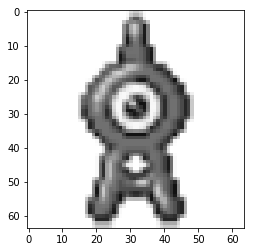

In [84]:
test_pkm_loc = os.path.join(os.getcwd(), "sprites","rse","unown.png")
test_im = mpimg.imread(test_pkm_loc)

plt.imshow(test_im)
print(test_im.ndim)

def pure_pil_alpha_to_color(image, color=(255, 255, 255)):
    image.load()
    background = Image.new("RGB", image.size, color)
    background.paste(image, mask=image.split()[3]) # 3 is the alpha channel
    return background

test_im = center_and_resize(test_im)
print(type(test_im))
#plt.imshow(test_im)
    

PIL_im = Image.fromarray(np.uint8(test_im*255))
PIL_im = PIL_im.convert(mode="RGBA")
print(PIL_im)

PIL_im = pure_pil_alpha_to_color(PIL_im)
print(PIL_im)
plt.imshow(PIL_im)

PIL_im.save(fp=os.path.join(os.getcwd(),"charmander.png"))

new_test_im = io.imread(os.path.join(os.getcwd(),"charmander.png"))
print(new_test_im.shape)
print(new_test_im)



(64, 64, 4)


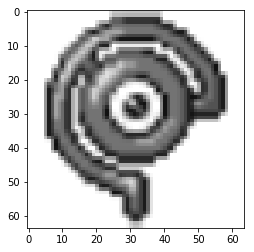

In [105]:
test_pkm_loc = os.path.join(os.getcwd(), "data","bw","unownc.png")
test_im = io.imread(test_pkm_loc)
plt.imshow(test_im)
print(test_im.shape)

In [106]:
#TEST_CODE




pkm_list = list(pokedex.keys())[0:10]

row_list = []

keys = ["pokemon","dex_number","normal","fighting","flying","poison","ground","rock","bug","ghost","steel","fire",
    "water","grass","electric","psychic","ice","dragon","dark","fairy"]
corr_num = [""]+[0]*(len(keys)-1)

for pkm in pkm_list:

    row_dict = dict(zip(keys, corr_num))

    row_dict["pokemon"] = pkm
    row_dict["dex_number"] = pokedex[pkm]["num"]
    
    for t in (t.lower() for t in pokedex[pkm]["types"]):
            row_dict[t] = 1
    
    row_list.append(row_dict)
    
df = pd.DataFrame(row_list,columns=keys)
print(df)
writeable_df = df.to_csv("testdf.csv",encoding="utf-8",index=False)
print(writeable_df)


          pokemon  dex_number  normal  fighting  flying  poison  ground  rock  \
0       bulbasaur           1       0         0       0       1       0     0   
1         ivysaur           2       0         0       0       1       0     0   
2        venusaur           3       0         0       0       1       0     0   
3    venusaurmega           3       0         0       0       1       0     0   
4      charmander           4       0         0       0       0       0     0   
5      charmeleon           5       0         0       0       0       0     0   
6       charizard           6       0         0       1       0       0     0   
7  charizardmegax           6       0         0       0       0       0     0   
8  charizardmegay           6       0         0       1       0       0     0   
9        squirtle           7       0         0       0       0       0     0   

   bug  ghost  steel  fire  water  grass  electric  psychic  ice  dragon  \
0    0      0      0     0      

In [68]:
#TEST CODE

print(pokedex["magby"]["types"])
types = ["normal","fighting","flying","poison","ground","rock","bug","ghost","steel","fire",
        "water","grass","electric","psychic","ice","dragon","dark","fairy"]
corr_num = range(2,len(types)+2)
print(len(types))
print(len(corr_num))

pkm_types_dict = {}
for i in range(0,len(types)):
    pkm_types_dict[types[i]] = corr_num[i]

print(pkm_types_dict)

df = pd.DataFrame(columns=["Pokemon","DexNum"]+types)

print(df)

['Fire']
18
18
{'normal': 2, 'fighting': 3, 'flying': 4, 'poison': 5, 'ground': 6, 'rock': 7, 'bug': 8, 'ghost': 9, 'steel': 10, 'fire': 11, 'water': 12, 'grass': 13, 'electric': 14, 'psychic': 15, 'ice': 16, 'dragon': 17, 'dark': 18, 'fairy': 19}
Empty DataFrame
Columns: [Pokemon, DexNum, normal, fighting, flying, poison, ground, rock, bug, ghost, steel, fire, water, grass, electric, psychic, ice, dragon, dark, fairy]
Index: []


/home/tariq/PokemonTypeNN/sprites/bw/mandibuzz.png


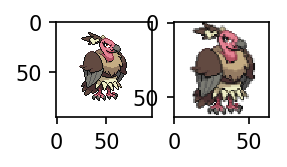

In [12]:
#TEST

main_folder = os.getcwd()
full_test_path = os.path.join(main_folder,"sprites","bw","mandibuzz.png")
print(full_test_path)
test_img = mpimg.imread(full_test_path)

rows = 14
cols = 14

plt.figure(figsize=(rows,cols),dpi=150)
plt.subplot(rows,cols,1)
plt.imshow(test_img)

resize_test_img = center_and_resize(test_img)
plt.subplot(rows,cols,2)
plt.imshow(resize_test_img)

plt.show()

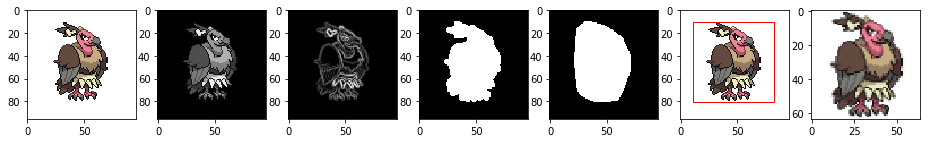

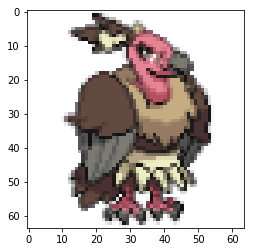

In [13]:
#TEST

resize_test_img = center_and_resize(test_img, plot=True)
plt.imshow(resize_test_img)